# Homework 4

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv -O credit.csv

--2022-10-02 09:43:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘credit.csv’

credit.csv          100%[===================>]  71.53K  --.-KB/s    in 0.03s   

2022-10-02 09:43:10 (2.29 MB/s) - ‘credit.csv’ saved [73250/73250]



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from tqdm.auto import tqdm

## Preparation

- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [3]:
# Data loading
df = pd.read_csv('credit.csv')

# Target variable
df['card'] = (df['card'] == 'yes').astype(int)

# Dataset splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [4]:
numerical = [
    'reports',
    'dependents',
    'active',
    'share'
]

auc = []
for n in numerical:
    auc.append(round(roc_auc_score(y_train, df_train[n]), 3))

print(sorted(list(zip(numerical, auc)), key=lambda k: k[1], reverse=True))

[('share', 0.989), ('active', 0.604), ('dependents', 0.467), ('reports', 0.283)]


### Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [5]:
features = [
    'reports',
    'age',
    'income',
    'share',
    'expenditure',
    'dependents',
    'months',
    'majorcards',
    'active',
    'owner',
    'selfemp'
]

dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.995

## Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [6]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [7]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

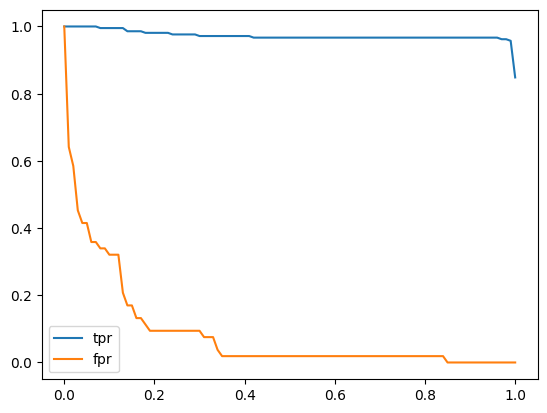

In [8]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='tpr')
plt.plot(df_scores.threshold, df_scores['fpr'], label='fpr')
plt.legend()

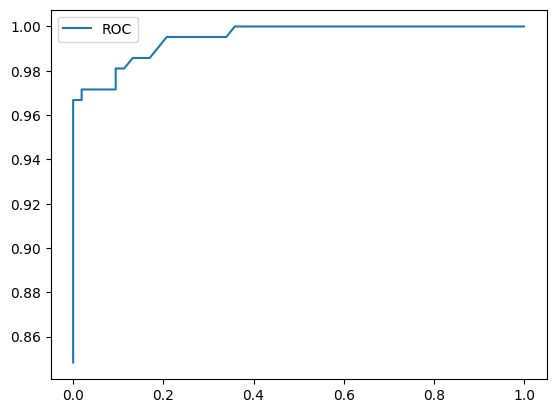

In [9]:
plt.plot(df_scores['fpr'], df_scores['tpr'], label='ROC')
plt.legend()

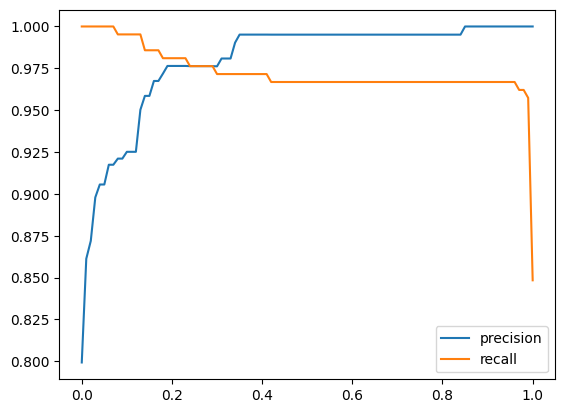

In [10]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

# Question 4

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

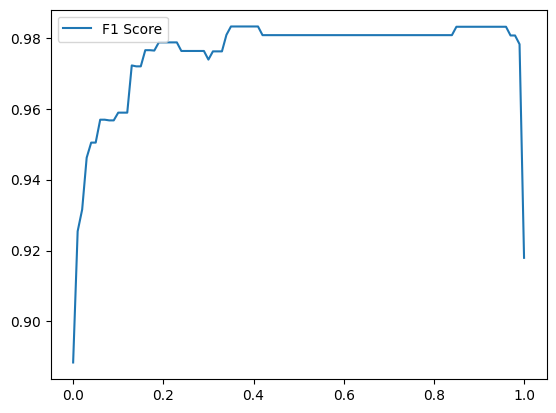

In [11]:
df_scores['f1-score'] = 2*df_scores['precision']*df_scores['recall']/(df_scores['precision']+df_scores['recall'])
plt.plot(df_scores.threshold, df_scores['f1-score'], label='F1 Score')
plt.legend()

# Question 5

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [12]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [13]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [14]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.std(scores)

0.0027434713804377724

## Question 6

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [15]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.996 +- 0.003
C=0.1 0.996 +- 0.003
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003
